# Grid path planning with dynamics

<a target="_blank" href="https://colab.research.google.com/github/arthurrichards77/smply/blob/master/grid_states.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This example uses a uniform grid for its roadmap, but extended over higher dimensions to include velocity states.

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [21]:
pos_step = 1.0
x_range = np.arange(0,10,pos_step)
y_range = np.arange(0,10,pos_step)

In [22]:
vmin = 1.0
vmax = 1.2
spd_range = np.linspace(vmin,vmax,3)
print(spd_range)

[1.  1.1 1.2]


In [23]:
num_angles = 8
hdg_range = np.arange(0,2*np.pi,2*np.pi/num_angles)
print(hdg_range)

[0.         0.78539816 1.57079633 2.35619449 3.14159265 3.92699082
 4.71238898 5.49778714]


In [24]:
turn_radius = 0.5
acc_limit = vmin**2/turn_radius
print(acc_limit)

2.0


In [25]:
grid_points = [(x,y,spd*np.cos(theta),spd*np.sin(theta)) for x in x_range for y in y_range for theta in hdg_range for spd in spd_range]
num_points = len(grid_points)
print(num_points)

2400


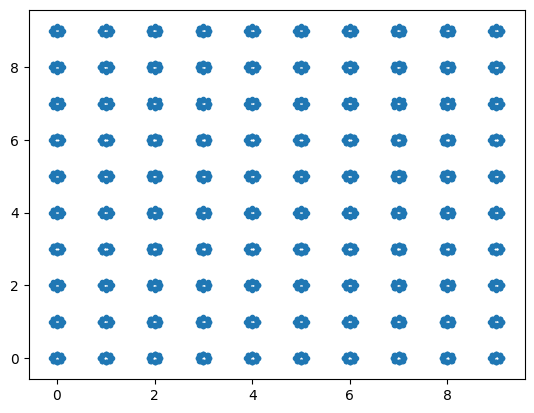

In [26]:
vel_scale = 0.1
plt.plot([p[0]+vel_scale*p[2] for p in grid_points],[p[1]+vel_scale*p[3] for p in grid_points],'.')

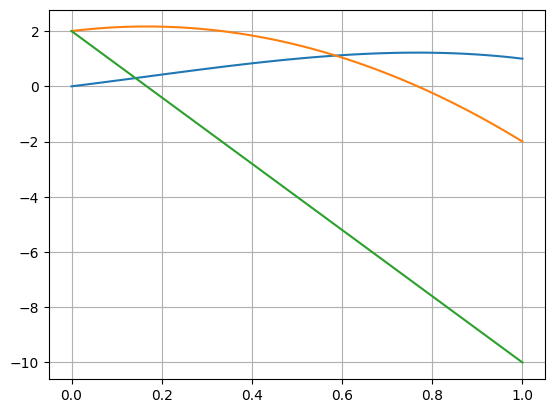

In [48]:
p0 = 0
v0 = 2
p1 = 1
v1 = -2

def fit_cubic(p0,p1,v0,v1):
    a = p0
    b = v0
    c = 3*(p1-p0) - v1 - 2*v0
    d = v1 + v0 - 2*(p1-p0)
    return a,b,c,d

a,b,c,d = fit_cubic(p0,p1,v0,v1)

def eval_cubic(a,b,c,d,s,deriv = 0):
    if deriv==0:
        return a + b*s + c*(s**2) + d*(s**3)
    elif deriv==1:
        return b + 2*c*s + 3*d*s**2
    elif deriv==2:
        return 2*c + 6*d*s
    else:
        raise(NotImplemented())

s = np.linspace(0,1,50)
p = eval_cubic(a,b,c,d,s)
v = eval_cubic(a,b,c,d,s,deriv=1)
a = eval_cubic(a,b,c,d,s,deriv=2)
plt.plot(s,p,s,v,s,a)
plt.grid('on')
plt.show()

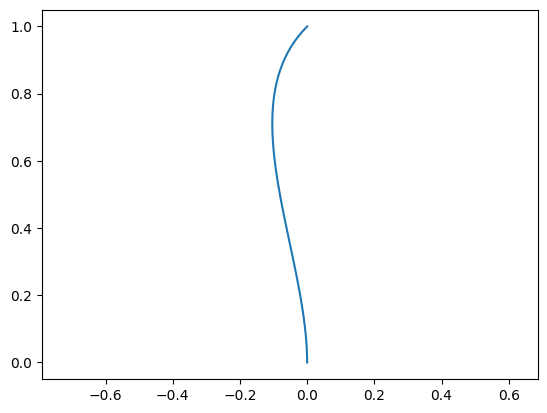

In [49]:
x1,y1,vx1,vy1 = 0,0,0,1
x2,y2,vx2,vy2 = 0,1,0.7,0.7

T = 1.0

ax,bx,cx,dx = fit_cubic(x1,x2,T*vx1,T*vx2)
ay,by,cy,dy = fit_cubic(y1,y2,T*vy1,T*vy2)

x = eval_cubic(ax,bx,cx,dx,s)
y = eval_cubic(ay,by,cy,dy,s)

plt.plot(x,y)
plt.axis('equal')
plt.show()

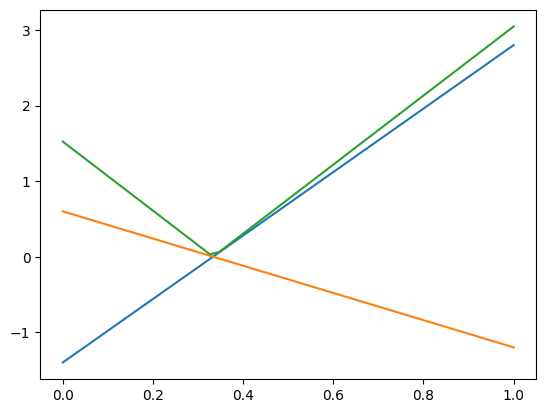

In [50]:
accx = eval_cubic(ax,bx,cx,dx,s,deriv=2)/T**2
accy = eval_cubic(ay,by,cy,dy,s,deriv=2)/T**2
accm = np.sqrt(accx**2 + accy**2)
plt.plot(s,accx,s,accy,s,accm)
plt.show()

In [ ]:
dist_lim = 1.75*pos_step
default_time = pos_step*2/(vmax+vmin)
print(default_time)

def travel_time(s1,s2):
    x1,y1,vx1,vy1 = s1
    x2,y2,vx2,vy2 = s2
    if x1==x2 and y1==y2:
        return np.inf,[],[]
    if (x2-x1)**2 + (y2-y1)**2 > dist_lim**2:
        return np.inf,[],[]
    #if (x2-x1)*vx1 < 0.0:
    #    return np.inf,[],[]
    #if (y2-y1)*vy1 < 0.0:
    #    return np.inf,[],[]
    #if (x2-x1)*vx2 < 0.0:
    #    return np.inf,[],[]
    #if (y2-y1)*vy2 < 0.0:
    #    return np.inf,[],[]
    T = default_time
    for ii in range(10):
        ax,bx,cx,dx = fit_cubic(x1,x2,T*vx1,vx2)
        ay,by,cy,dy = fit_cubic(y1,y2,T*vy1,vy2)
        acc0 = np.sqrt((2*cx)**2 + (2*cy)**2)/T**2
        acc1 = np.sqrt((2*cx + 6*dx)**2 + (2*cy + 6*dy)**2)/T**2
        acc_max = max(acc0,acc1)
        #print(T,acc_max)
        if acc_max > acc_limit:
            T = T*2
        else:
            break
    if T>default_time:
        T_high = T
        T_low = T/2
        for ii in range(5):
            T = 0.5*(T_high+T_low)
        ax,bx,cx,dx = fit_cubic(x1,x2,T*vx1,T*vx2)
        ay,by,cy,dy = fit_cubic(y1,y2,T*vy1,T*vy2)
        acc0 = np.sqrt((2*cx)**2 + (2*cy)**2)/T**2
        acc1 = np.sqrt((2*cx + 6*dx)**2 + (2*cy + 6*dy)**2)/T**2
        acc_max = max(acc0,acc1)
        #print(T,acc_max)
        if acc_max > acc_limit:
            T_high = T
        else:
            T_low = T
    s = np.linspace(0,1,20)
    return T,ax+bx*s+cx*s**2+dx*s**3,ay+by*s+cy*s**2+dy*s**3


0.9090909090909091


In [53]:
s1 = (0.0,0.0,1.0,0.0)
s2 = (1.0,0.1,1.0,0.0)
t,x,y = travel_time(s1,s2)
print(t)
plt.plot(x,y)
plt.plot(s1[0],s1[1],'g+')
plt.plot(s2[0],s2[1],'g^')
plt.axis('equal')
plt.show()

TypeError: fit_cubic() takes 4 positional arguments but 5 were given

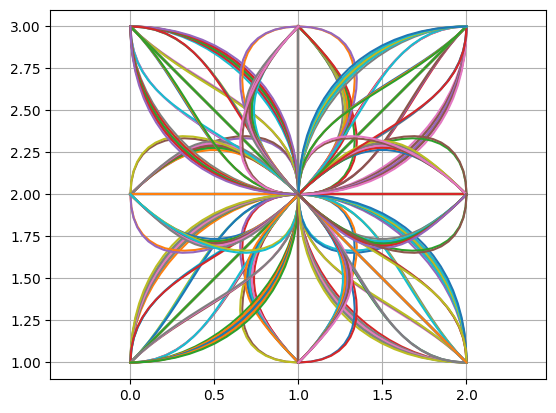

In [34]:
for (i1,s1) in enumerate(grid_points):
    if (s1[0],s1[1])!=(1.0,2.0):
        continue
    for (i2,s2) in enumerate(grid_points):
        t12,x,y = travel_time(s1,s2)
        if t12 < 3.0:
            plt.plot(x,y,'-')
plt.axis('equal')
plt.grid('on')
plt.show()

In [35]:
cost_matrix = np.inf*np.ones((num_points,num_points))
link_matrix = {}
for (i1,s1) in enumerate(grid_points):
    for (i2,s2) in enumerate(grid_points):
        t12,x,y = travel_time(s1,s2)
        if t12 < 3.0:
            cost_matrix[i1,i2] = t12
            link_matrix[(i1,i2)] = (x,y)

In [36]:
from scipy.sparse.csgraph import shortest_path
path_length,predecessors = shortest_path(cost_matrix, return_predecessors=True)

In [39]:
start_node = 120
target_node = 1600
print(grid_points[start_node])
print(grid_points[target_node])
print(path_length[start_node,target_node])

(0.0, 5.0, 1.0, 0.0)
(6.0, 6.0, -0.7778174593052025, -0.7778174593052023)
8.5


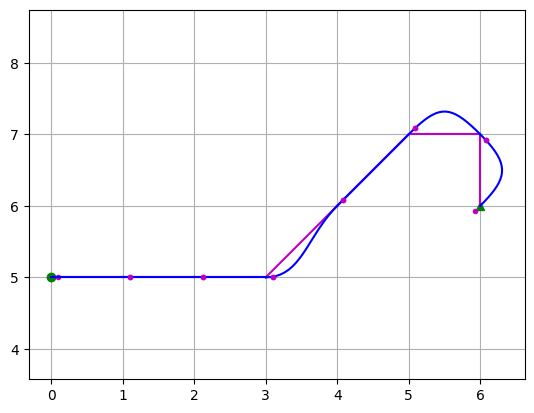

In [40]:
plt.plot([grid_points[start_node][0]],
         [grid_points[start_node][1]],'go')
plt.plot([grid_points[target_node][0]],
         [grid_points[target_node][1]],'g^')
curr_node = target_node
for kk in range(len(grid_points)):
    prev_node = predecessors[start_node,curr_node]
    plt.plot([grid_points[curr_node][0] + vel_scale*grid_points[curr_node][2],
              grid_points[prev_node][0] + vel_scale*grid_points[prev_node][2]],
             [grid_points[curr_node][1] + vel_scale*grid_points[curr_node][3],
              grid_points[prev_node][1] + vel_scale*grid_points[prev_node][3]],'m.')
    plt.plot([grid_points[curr_node][0],
              grid_points[prev_node][0]],
             [grid_points[curr_node][1],
              grid_points[prev_node][1]],'m-')
    px,py = link_matrix[(prev_node,curr_node)]
    plt.plot(px,py,'b-')
    curr_node=prev_node
    if curr_node==start_node:
        break
plt.grid('on')
plt.axis('equal')
plt.show()